In [1]:
# This notebook looks into how existing vanilla transformers do math

In [2]:
# ----- dependencies
!pip install transformers 
#!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
!pip install -U huggingface_hub
!pip install -U accelerate
!pip install --upgrade pip
!pip install torch

# ----- dependencies
import os
import torch
from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
from huggingface_hub import login
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:

# ----- HYPERPARAMETERS
LLM_context_length = 20 
LLM_hid =      128 # from https://arxiv.org/pdf/2307.03381.pdf Teaching arithmetic to smalltansformers
LLM_layers =   4
LLM_n_heads =  4

# --- training
batch_size = 256
iterations = 10000
epochs = 1





# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size







# ------- Initialize model

# --- Create non-causal concept encoder (C) (tokens to concepts)
# the final autorecressive decoder-only model will use itself as the encoder - note that for char-level or removing tokenizer dependency we will need a separate encoder so that decoder take in only high level concepts
half_config = LlamaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=LLM_hid,
    intermediate_size=LLM_hid*4,
    num_hidden_layers=LLM_layers,
    num_attention_heads=LLM_n_heads,
    num_key_value_heads=None,
    hidden_act='silu',
    max_position_embeddings=LLM_context_length,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=None,
    bos_token_id=tokenizer.bos_token,
    eos_token_id=tokenizer.eos_token,
    pretraining_tp=1,
    tie_word_embeddings=False,
    rope_theta=10000.0,
    rope_scaling=None)

# --- Create causal concept decoder (D) (concepts to concepts)
LLM_decoder = LlamaForCausalLM(half_config).to(device)#.to(torch.bfloat16)
LLM_decoder.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(16, 128)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=128, out_features=128, bias=False)
          (k_proj): Linear(in_features=128, out_features=128, bias=False)
          (v_proj): Linear(in_features=128, out_features=128, bias=False)
          (o_proj): Linear(in_features=128, out_features=128, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=128, out_features=512, bias=False)
          (up_proj): Linear(in_features=128, out_features=512, bias=False)
          (down_proj): Linear(in_features=512, out_features=128, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_featur

In [4]:
import random
eval_pairs = []
for i in range((2000//batch_size)*batch_size):
    eval_pairs.append((random.randint(0, 999), random.randint(0, 999)))
len(eval_pairs)



def batch(batch_size, ctx):
    
    # get batch x, y
    batch_input_ids = torch.zeros([batch_size,ctx],dtype=torch.long)
    for b_idx in range(batch_size):
        num1,num2=eval_pairs[0]
        while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
            num1 = random.randint(0, 999)
            num2 = random.randint(0, 999)
        result = str(num1 + num2)
        problem = f"{num1}+{num2}={result}"
        tokenized = tokenizer.tokenize(problem, max_length=ctx)
        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
    labels = batch_input_ids.clone()
    labels[labels==tokenizer.pad_token] = -100

    return batch_input_ids, labels

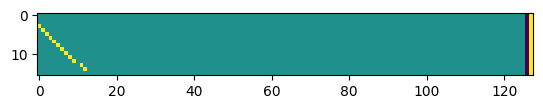

In [5]:
# edit embeddings to give each number a corresponding 1-hot
# ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']

# assign neurons to digits 0-9
LLM_decoder.model.embed_tokens.weight.data[:] = 0
for i in range(10):
    LLM_decoder.model.embed_tokens.weight.data[i+3,i] = .1
LLM_decoder.model.embed_tokens.weight.data[13,11] = .1 # +
LLM_decoder.model.embed_tokens.weight.data[14,12] = .1 # =

# creating a pos/neg spike in all embeddings survives normalization and can be used as a bias

LLM_decoder.model.embed_tokens.weight.data[:,-1] = .1
LLM_decoder.model.embed_tokens.weight.data[:,-2] = -.1

import matplotlib.pyplot as plt
plt.imshow(LLM_decoder.model.embed_tokens.weight.data)

In [6]:
# train MLP to take in rotary embedding and produce the previous one
head_size = LLM_hid//LLM_n_heads
rotary_to_1hot32 = torch.nn.Linear(head_size, head_size)




In [10]:
# edit attention 1 as identity
print(LLM_decoder.model.layers[0].self_attn) # shouldnt there be multiple of each or each head?
head_size = 128//LLM_n_heads
identity_matrix = torch.eye(head_size, head_size)

# make attention close to identity - we just want to pass tokens forward. edit this to just depend on positional embedding
LLM_decoder.model.layers[0].self_attn.q_proj.weight.data = torch.ones(128,128)
LLM_decoder.model.layers[0].self_attn.k_proj.weight.data = torch.ones(128,128)

# pass values through unaltered
LLM_decoder.model.layers[0].self_attn.v_proj.weight.data = torch.eye(128,128)
LLM_decoder.model.layers[0].self_attn.o_proj.weight.data = torch.eye(128,128)


LlamaAttention(
  (q_proj): Linear(in_features=128, out_features=128, bias=False)
  (k_proj): Linear(in_features=128, out_features=128, bias=False)
  (v_proj): Linear(in_features=128, out_features=128, bias=False)
  (o_proj): Linear(in_features=128, out_features=128, bias=False)
  (rotary_emb): LlamaRotaryEmbedding()
)


In [8]:
# edit MLP 1 to provide positional encoding to each digit

# MLP should do:
    # take in embedding from head 1

    # for first number (if there is no plus sign seen), assign positional embedding on head 2

    # if there is a plus sign and no positional embedding on head 3, assign positional embedding #1 on head 3
    # if there is a plus sign and positional embedding M on head 3, assign positional embedding #M+1 on head 3


LLM_decoder.model.layers[0].mlp.gate_proj.weight.data[:] = 1
LLM_decoder.model.layers[0].mlp.up_proj.weight.data[:] = 0
LLM_decoder.model.layers[0].mlp.down_proj.weight.data[:] = 0

# --- remember that the input is normalized - biases
# create neuron to check for + symbol
LLM_decoder.model.layers[0].mlp.up_proj.weight.data[13, 13] = 1


# HEAD 1 TRACKS INDIVIDUAL WORD EMBEDDINGS
# HEAD 2 TRACKS PAST WORD EMBEDDINGS

# HEAD 3 TRACKS NUM 1 DIGIT PLACE VALUES

# HEAD 4 TRACKS NUM 2 DIGIT PLACE VALUES

# HEAD 5 TRACKS MATCHED DIG PLACE VALUES
# HEAD 6 position of digit we are looking for

# ALGORITHM:
# layer 0 att: 
#   head 1: word embeddings are passed through directly. key & query = positional embedding. value = embed[0:head_size]
#   head 2: attend to everyhting equally (key&query = 0, v=0:head_size) - this is a general detector for everything. future MLP layer can look at this and see what tokens have been seen
# layer 0 MLP: 
#               if head 1 is digit AND NOT + in head 2:
#                       read head 3 position. if head3==0, do nothing. if head3>0, output head3+1. set head 4 to 0
#               if head 1 is digit AND + head 2, get token distance from + add this positional encoding to head 4. 
#               if head 1 is = set head 6 to current positional embedding -1. else set head 6 to current positional embedding.  (implement this every layer. therefore, at = sign, head 6 wil go up num 2 positional embeddings)
#              
#
# layer 1 att: 
#   head 1: 
#   head 2: 
#   head 3:
# layer 1 MLP: 

# always enable position 1 on head 2 (nu)
LLM_decoder.model.layers[0].mlp.up_proj.weight.data[-1, head_size] = 1 # refer to the spike/"bias" in embeddings to ensure this is always 1
# if see position 1 in past, enable position 2 at MLP 1 of llama the only positional info we have is rotary encodings
LLM_decoder.model.layers[0].mlp.up_proj.weight.data[head_size:2*head_size, head_size] = 1 # refer to the spike/"bias" in embeddings to ensure this is always 1
LLM_decoder.model.layers[0].mlp.down_proj.weight.data[head_size:2*head_size, head_size] = 1 # refer to the spike/"bias" in embeddings to ensure this is always 1
# if see position 2 in past, enable position 2 at MLP 1 of llama the only positional info we have is rotary encodings
LLM_decoder.model.layers[0].mlp.up_proj.weight.data[head_size:2*head_size, head_size+1] = 1 # refer to the spike/"bias" in embeddings to ensure this is always 1
LLM_decoder.model.layers[0].mlp.down_proj.weight.data[head_size:2*head_size, head_size+1] = 1 # refer to the spike/"bias" in embeddings to ensure this is always 1

# only output the position if this is the first digit (no + seen)
LLM_decoder.model.layers[0].mlp.down_proj.weight.data[13, head_size:2*head_size] = -1 # + token downweights all head 2 positions
LLM_decoder.model.layers[0].mlp.down_proj.weight.data[head_size:2*head_size, head_size:2*head_size] = 1 # head 2 positions to head 2 positions


# enable position (head 1 position) on head 2






tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [6.5181, 6.5181, 6.5181,  ..., 6.5181, 6.5181, 6.5181],
          [6.5181, 6.5181, 6.5181,  ..., 6.5181, 6.5181, 6.5181],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [6.5181, 6.5181, 6.5181,  ..., 6.5181, 6.5181, 6.5181],
          [6.5181, 6.5181, 6.5181,  ..., 6.5181, 6.5181, 6.5181],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [6.5181, 6.5181, 6.5181,  ..., 6.5181, 6.5181, 6.5181],
          [6.5181, 6.5181, 6.5181,  ..

<IPython.core.display.Javascript object>

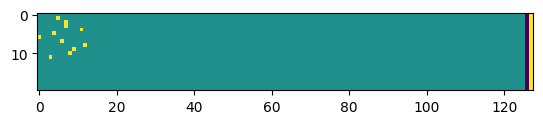

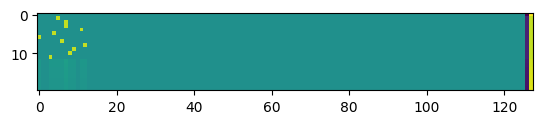

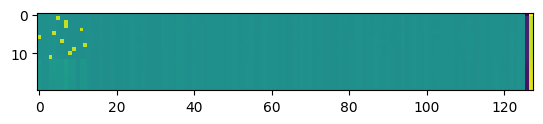

In [11]:
#import sys
#!{sys.executable} -m pip install bertviz

from bertviz import model_view

# create math input
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
num1 = random.randint(0, 999)
num2 = random.randint(0, 999)
result = str(num1 + num2)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)

labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -100

# forward pass
LLM_decoder.eval()
with torch.no_grad():
    output = LLM_decoder(input_ids=batch_input_ids.to(device), labels=labels.to(device), output_attentions=True, output_hidden_states=True) 
attention = output[-1]

# show hidden states
#plt.imshow(output.hidden_shapes)
#plt.plot()


a=tokenizer.detokenize(tokenized)
model_view(attention, a.replace('<s>', '_').replace('</s>', '_').replace('<pad>', '_'))



state = output.hidden_states
plt.imshow(state[0][0])
plt.show()

plt.imshow(state[1][0])
plt.show()

plt.imshow(state[2][0])
plt.show()
